# Data Exploration - Similarity

In this notebook, we will explore some models to use as similarity measure in our domain.

The focus is choose one of them for the semantic similarity metric.


## Libs and Variables

In [13]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from wordllama import WordLlama
from wordllama.inference import WordLlamaInference
from langchain_ollama import OllamaLLM

import seaborn as sns

In [2]:
def seed_all():
    """
    Seed all the random number generators to ensure reproducibility.

    This function sets the seed for the Python built-in random module and the NumPy random module to 42.
    This ensures that any random operations performed using these modules will produce the same results
    each time the code is run.
    """
    random.seed(42)
    np.random.seed(42)


seed_all()

In [3]:
DATA_PATH = "../data/data.csv"

## Load data

In [4]:
data = pd.read_csv(DATA_PATH)

data["question"] = data["question"].astype(str)
data["answer"] = data["answer"].astype(str)

In [5]:
data.sample(5).style

,question,answer
3634,Is Juvenile Huntington disease inherited ?,"How is Juvenile Huntington disease (HD) inherited? Juvenile HD is inherited in an autosomal dominant manner, which means that one copy of the altered gene in each cell is sufficient to cause the disorder. An affected person usually inherits the altered gene from one affected parent. As the altered HTT gene is passed from one generation to the next, the size of the CAG trinucleotide repeat often increases in size. A larger number of repeats is usually associated with an earlier onset of signs and symptoms (anticipation). A larger number of repeats is usually associated with an earlier onset of signs and symptoms. Most often, children with juvenile HD inherit the expanded CAG trinucleotide repeat from their fathers, although on occasion they inherit it from their mothers."
13745,What are the treatments for nemaline myopathy ?,These resources address the diagnosis or management of nemaline myopathy: - Gene Review: Gene Review: Nemaline Myopathy - Genetic Testing Registry: Nemaline myopathy - Genetic Testing Registry: Nemaline myopathy 1 - Genetic Testing Registry: Nemaline myopathy 10 - Genetic Testing Registry: Nemaline myopathy 2 - Genetic Testing Registry: Nemaline myopathy 3 - Genetic Testing Registry: Nemaline myopathy 4 - Genetic Testing Registry: Nemaline myopathy 5 - Genetic Testing Registry: Nemaline myopathy 6 - Genetic Testing Registry: Nemaline myopathy 7 - Genetic Testing Registry: Nemaline myopathy 8 - Genetic Testing Registry: Nemaline myopathy 9 These resources from MedlinePlus offer information about the diagnosis and management of various health conditions: - Diagnostic Tests - Drug Therapy - Surgery and Rehabilitation - Genetic Counseling - Palliative Care
4395,What is (are) Hailey-Hailey disease ?,"Hailey-Hailey disease is a hereditary blistering skin disease. Signs and symptoms include a painful rash and blistering in skin folds such as the armpits, groin, neck, under the breasts, and between the buttocks. Secondary bacterial infections are not uncommon. Symptoms are often worse in summer months due to heat, sweating and friction. Hailey-Hailey disease is caused by mutations in the ATP2C1 gene and is inherited in an autosomal dominant manner. Treatment focuses on reducing symptoms and preventing flares."
10274,Is transthyretin amyloidosis inherited ?,"This condition is inherited in an autosomal dominant pattern, which means one copy of the altered gene in each cell is sufficient to cause the disorder. In most cases, an affected person inherits the mutation from one affected parent. Rarely, cases result from new mutations in the gene and occur in people with no history of the disorder in their family. Not all people who have a TTR gene mutation will develop transthyretin amyloidosis."
149,How many people are affected by Balance Problems ?,"In 2008, an estimated 14.8 percent of American adults (33.4 million) had a balance or dizziness problem during the past year. See statistics about the frequency of balance and other sensory impairments in older adults. (Centers for Disease Control and Prevention)"


## Similarity models test

In [48]:
def similarity(essay1, essay2, model):
    if type(model) == WordLlamaInference:
        return model.similarity(essay1, essay2)
    elif type(model) == SentenceTransformer:
        embd1 = model.encode(essay1, show_progress_bar=False)
        embd2 = model.encode(essay2, show_progress_bar=False)
        return model.similarity(embd1, embd2).item()


def plot_similarity_distribution(sample, model, model_name):
    plt.figure(figsize=(8, 6))
    sns.kdeplot(
        sample["qa_similarity"],
        fill=True,
        label="Q -> A (High Similarity)",
        color="blue",
    )
    sns.kdeplot(
        sample["qra_similarity"],
        fill=True,
        label="Q -> Random A (Low Similarity)",
        color="orange",
    )
    sns.kdeplot(
        sample["ara_similarity"],
        fill=True,
        label="A -> Random A (Low Similarity)",
        color="green",
    )

    sns.kdeplot(
        sample["qsa_similarity"],
        fill=True,
        label="Q -> Similar A (High Similarity)",
        color="red",
    )

    sns.kdeplot(
        sample["asa_similarity"],
        fill=True,
        label="A -> Similar A (High Similarity)",
        color="purple",
    )

    # Title and labels
    plt.title(f"Similarity Distribution - {model.__class__.__name__} - {model_name}")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.legend(loc="upper right")
    plt.savefig(
        f"../figs/similarities/result_{model_name.replace('/', '_').replace('-', '_')}.png"
    )

    plt.show()

Let's create a small sample to validate the better models who can discrimine the question and the answer based on semantic similarity.

The ideia is create N samples that are expectec to have high similarity and relate them to other random answers.

Also add a summarized / variant of the answer generate by an LLM to observe if a expected similar answer has high similarity scores.

In [49]:
N = 10

llm = OllamaLLM(model="llama3.2:1b")

prompt = """
Rephrase the providen text without change the meaning.
Answer only the rephrased text, don't include the original text or additional information.
Try to generate near number of words than the original text.

Text:
{text}
"""

In [43]:
data["answer"].iloc[0]

"Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.)  See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more.  See a glossary of glaucoma terms."

In [44]:
llm.invoke(prompt.format(text=data["answer"].iloc[0]))

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


"Glaucoma is a serious eye condition affecting millions worldwide, causing vision loss and total blindness over time due to damage to the optic nerve. Early treatment can significantly reduce the risk of severe vision loss if not caught early on. To better understand this complex issue, watch our video (expand it to see more) or click on the links below to learn more about glaucoma. Here's a quick guide that covers key points, including how many people are affected, who is at high risk, what steps to take if you have symptoms and where to find further information for those seeking more knowledge. A glossary of terms specific to this topic will help clarify any confusion."

In [45]:
sample = data.sample(N, random_state=42).copy()

# Get N random answers from the dataset who the question are not selected in sample (same domain)
sample["random_answer"] = (
    data[~data["question"].isin(sample["question"])].sample(N)["answer"].values
)

sample["similar_answer"] = sample.apply(
    lambda row: llm.invoke(prompt.format(text=row["answer"])), axis=1
)

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


### Sentence T5 Base

In [56]:
model_name = "sentence-transformers/sentence-t5-base"
model = SentenceTransformer(model_name)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/sentence-t5-base


In [68]:
answer = ["hello", "test"]
true_answer = [["hi"], ["testing"]]


def unpack_true_answer(true_answer):
    return [i[0] for i in true_answer]


answer_embedding = model.encode(answer, show_progress_bar=False)
true_answer_embedding = model.encode(
    unpack_true_answer(true_answer), show_progress_bar=False
)

type(model.similarity_pairwise(answer_embedding, true_answer_embedding).numpy())

numpy.ndarray

In [51]:
for i, row in tqdm(sample.iterrows(), total=sample.shape[0]):

    # Question -> Answer (Expect high similarity)
    sample.loc[i, "qa_similarity"] = similarity(row["question"], row["answer"], model)

    # Question -> Similar Answer (Expect high similarity)
    sample.loc[i, "qsa_similarity"] = similarity(
        row["question"], row["similar_answer"], model
    )

    # Answer -> Similar Answer (Expect high similarity)
    sample.loc[i, "asa_similarity"] = similarity(
        row["answer"], row["similar_answer"], model
    )

    # Question -> Random Answer (Expect low similarity)
    sample.loc[i, "qra_similarity"] = similarity(
        row["question"], row["random_answer"], model
    )

    # Answer -> Random Answer (Expect low similarity)
    sample.loc[i, "ara_similarity"] = similarity(
        row["answer"], row["random_answer"], model
    )

  0%|          | 0/10 [00:00<?, ?it/s]

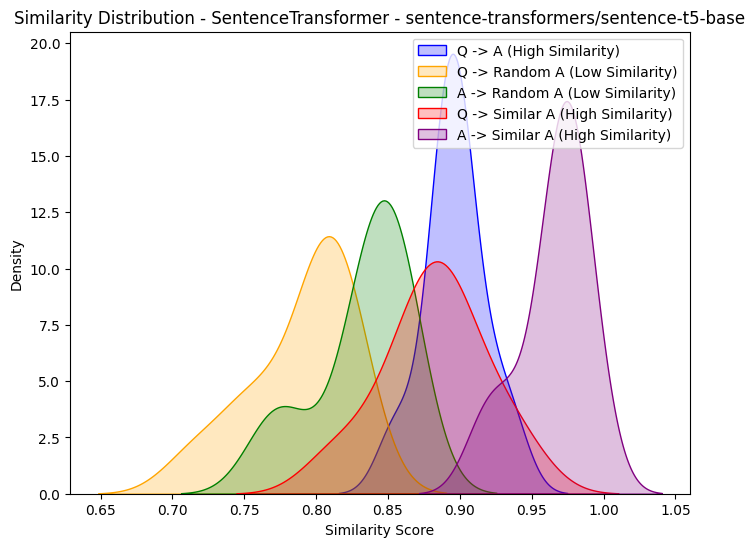

In [52]:
plot_similarity_distribution(sample, model, model_name)

### Some wordllama models

  0%|          | 0/10 [00:00<?, ?it/s]

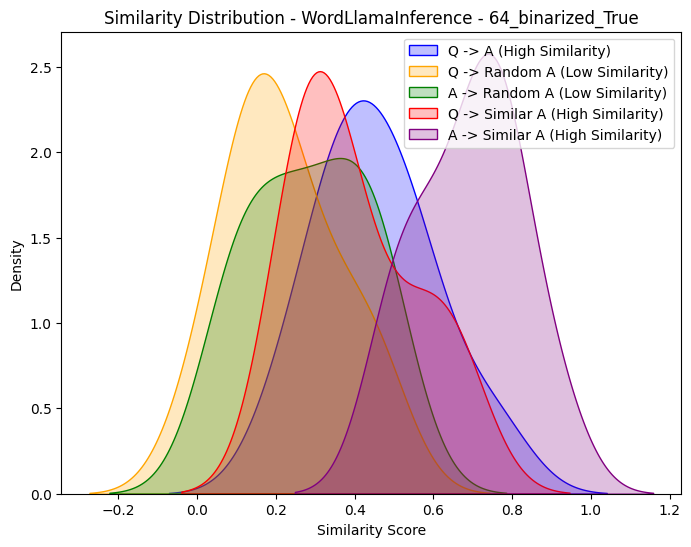

  0%|          | 0/10 [00:00<?, ?it/s]

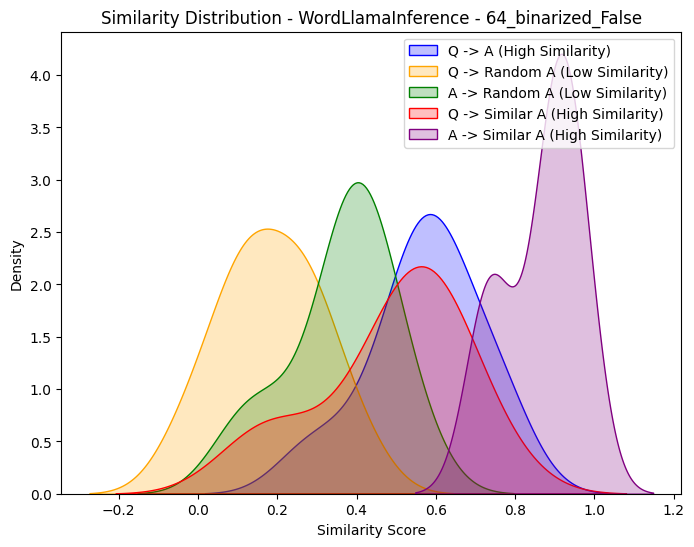

  0%|          | 0/10 [00:00<?, ?it/s]

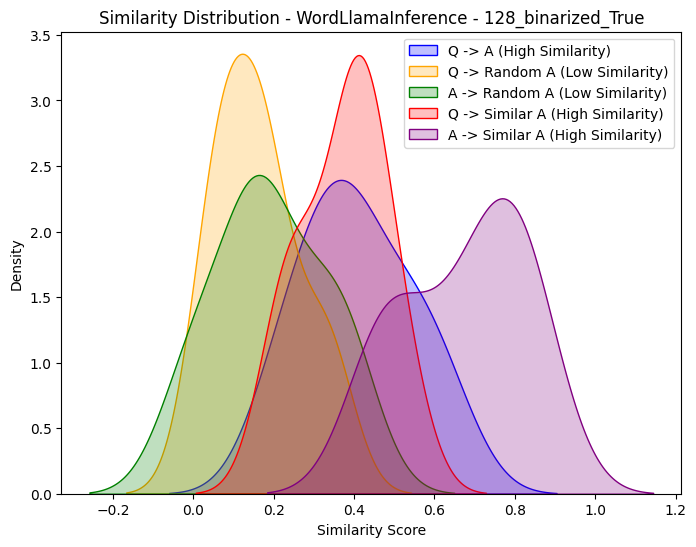

  0%|          | 0/10 [00:00<?, ?it/s]

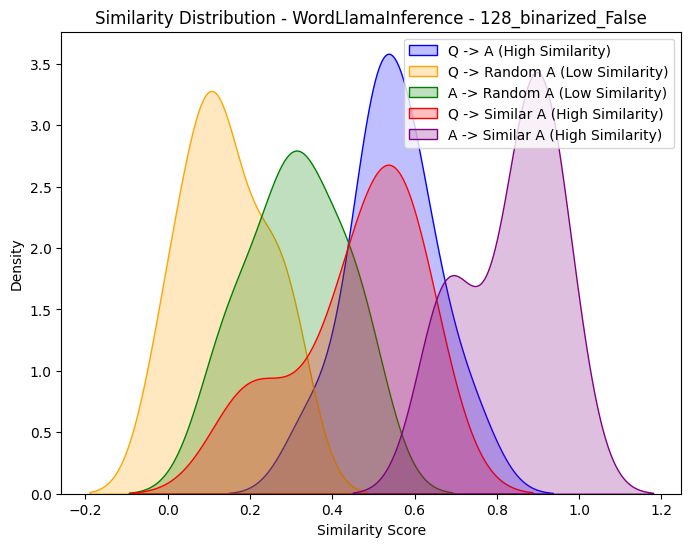

  0%|          | 0/10 [00:00<?, ?it/s]

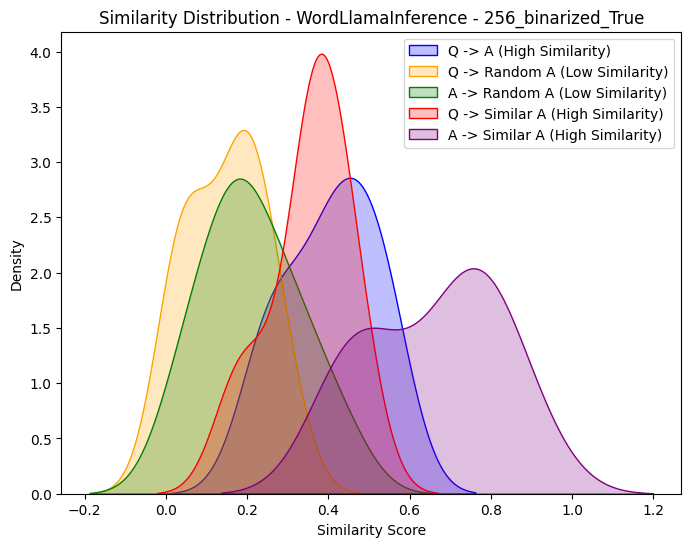

  0%|          | 0/10 [00:00<?, ?it/s]

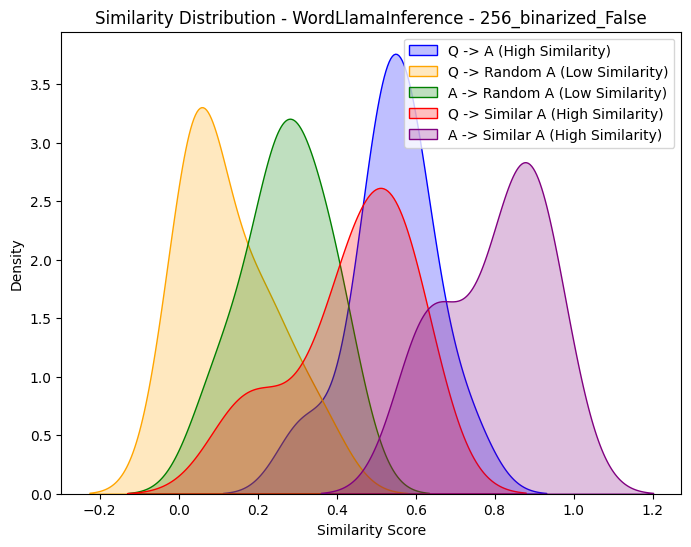

  0%|          | 0/10 [00:00<?, ?it/s]

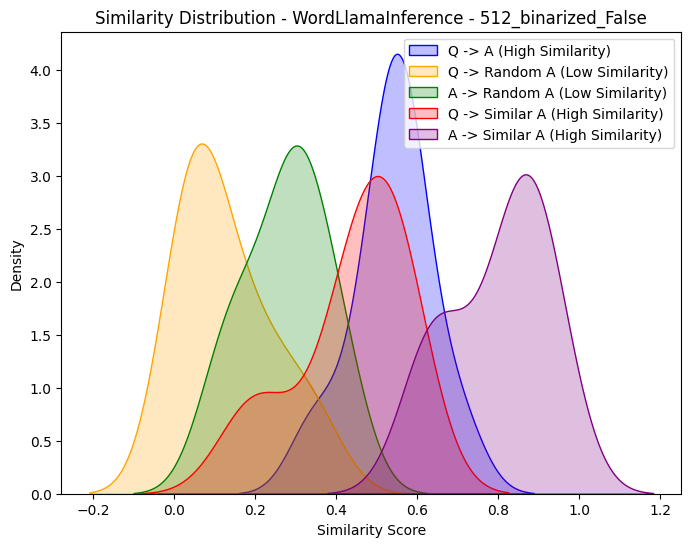

  0%|          | 0/10 [00:00<?, ?it/s]

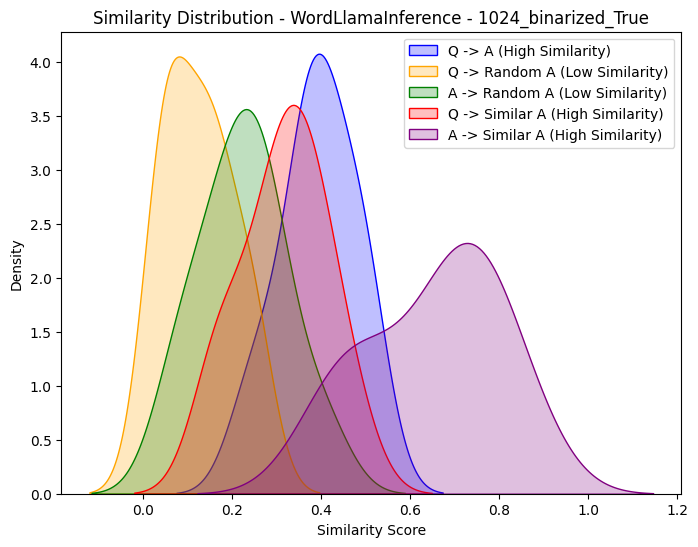

  0%|          | 0/10 [00:00<?, ?it/s]

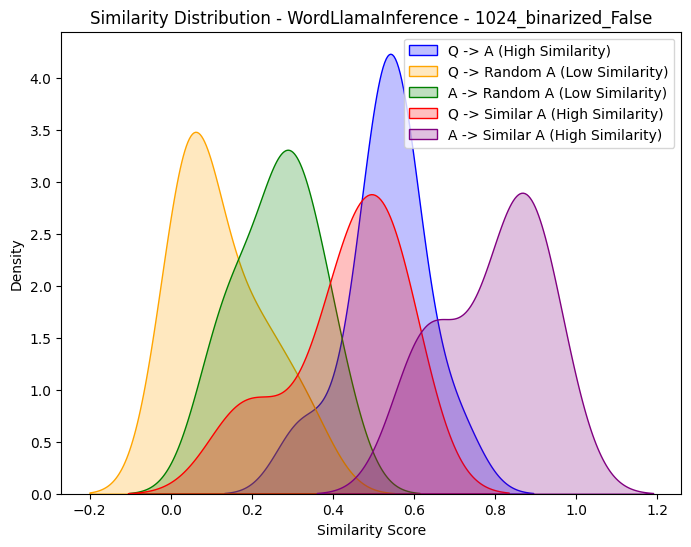

In [54]:
model_dim = [64, 128, 256, 512, 1024]
binary = [True, False]

for dim in model_dim:
    for bin in binary:

        try:
            model = WordLlama.load(dim=dim, binary=bin)
            model_name = f"{dim}_binarized_{bin}"
        except:
            # Skip if model is not available
            continue

        for i, row in tqdm(sample.iterrows(), total=sample.shape[0]):

            # Question -> Answer (Expect high similarity)
            sample.loc[i, "qa_similarity"] = similarity(
                row["question"], row["answer"], model
            )

            # Question -> Random Answer (Expect low similarity)
            sample.loc[i, "qra_similarity"] = similarity(
                row["question"], row["random_answer"], model
            )

            # Answer -> Random Answer (Expect low similarity)
            sample.loc[i, "ara_similarity"] = similarity(
                row["answer"], row["random_answer"], model
            )

            # Question -> Similar Answer (Expect high similarity)
            sample.loc[i, "qsa_similarity"] = similarity(
                row["question"], row["similar_answer"], model
            )

            # Answer -> Similar Answer (Expect high similarity)
            sample.loc[i, "asa_similarity"] = similarity(
                row["answer"], row["similar_answer"], model
            )

        plot_similarity_distribution(sample, model, model_name)